###Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


###Importing Dataset

In [ ]:
dataset = pd.read_csv('Train.csv')
dataset

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real
...,...,...,...
8555,8556,Donald Trump wrongly claimed that New Zealand ...,fake
8556,8557,Current understanding is #COVID19 spreads most...,real
8557,8558,Nothing screams “I am sat around doing fuck al...,fake
8558,8559,Birx says COVID-19 outbreak not under control ...,fake


##Preprocessing


###Function to remove noise

In [ ]:
import re
def remove_noise(input):
    input = str(input).lower()
    new_text = re.sub('[^a-z+]', ' ',input)
    return new_text 

###Function to remove stopwords

In [ ]:
stopwords_list = stopwords.words('english')
stopwords_list.append(['the','a','an'])
def remove_stopwords(input_text):
    # input_text = str(input_text).lower()
    words = str(input_text).split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 1] 
    return " ".join(clean_words)

###Applying these functions to column containing tweets

In [ ]:
dataset.tweet = dataset.tweet.apply(remove_noise)
dataset.tweet = dataset.tweet.apply(remove_stopwords)
dataset

,id,tweet,label
0,1,cdc currently reports deaths general discrepan...,real
1,2,states reported deaths small rise last tuesday...,real
2,3,politically correct woman almost uses pandemic...,fake
3,4,indiafightscorona covid testing laboratories i...,real
4,5,populous states generate large case counts loo...,real
...,...,...,...
8555,8556,donald trump wrongly claimed new zealand big s...,fake
8556,8557,current understanding covid spreads mostly per...,real
8557,8558,nothing screams sat around fuck lockdown quite...,fake
8558,8559,birx says covid outbreak control people move h...,fake


###Calculating the number of average words in a news

In [ ]:
total = 0
for tweet in dataset.tweet:
    words = str(tweet).split()
    total = total + len(words)
print(total/8560)

18.1821261682243


###Limiting the number of words in a news so that all the news contains same number of words 

In [ ]:
max_length = 20

def truncate(input_text):
    words = str(input_text).split() 
    if len(words)>max_length:
        del words[max_length:]
    elif len(words)<max_length:
        words = words + ['nan'] * (max_length-len(words)) 
    return " ".join(words)

In [ ]:
dataset.tweet = dataset.tweet.apply(truncate)
dataset

,id,tweet,label
0,1,cdc currently reports deaths general discrepan...,real
1,2,states reported deaths small rise last tuesday...,real
2,3,politically correct woman almost uses pandemic...,fake
3,4,indiafightscorona covid testing laboratories i...,real
4,5,populous states generate large case counts loo...,real
...,...,...,...
8555,8556,donald trump wrongly claimed new zealand big s...,fake
8556,8557,current understanding covid spreads mostly per...,real
8557,8558,nothing screams sat around fuck lockdown quite...,fake
8558,8559,birx says covid outbreak control people move h...,fake


In [ ]:
# news = dataset['tweet'].to_numpy()
labels = dataset['label'].to_numpy()
# print(news)
print(labels)

['real' 'real' 'fake' ... 'fake' 'fake' 'real']


In [ ]:
news = dataset.tweet
news

0       cdc currently reports deaths general discrepan...
1       states reported deaths small rise last tuesday...
2       politically correct woman almost uses pandemic...
3       indiafightscorona covid testing laboratories i...
4       populous states generate large case counts loo...
                              ...                        
8555    donald trump wrongly claimed new zealand big s...
8556    current understanding covid spreads mostly per...
8557    nothing screams sat around fuck lockdown quite...
8558    birx says covid outbreak control people move h...
8559    another new coronavirus cases confirmed uk hig...
Name: tweet, Length: 8560, dtype: object

###Creating sequences from raw text. 
(A "sequence" is a list of integer word indices.)

In [ ]:
vocab_size = 12000

tokenizer = Tokenizer(num_words=vocab_size) # Setup tokenizer
tokenizer.fit_on_texts(news)
sequences = tokenizer.texts_to_sequences(news) # Generate sequences

In [ ]:
print ("total number of sequences:", len(sequences))
print ("length of one sequence:", len(sequences[0]))
print ("sequence of first news:", sequences[0])

total number of sequences: 8560
length of one sequence: 20
sequence of first news: [56, 173, 174, 13, 361, 5120, 76, 1180, 391, 1661, 654, 7264, 76, 561, 507, 1547, 8, 18, 1, 1]


###Saving the tokenizer object to a file

In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

###Total number of unique words identified by the tokenizer

In [ ]:
word_index = tokenizer.word_index
print('Found {:,} unique words.'.format(len(word_index)))
# vocab_size = len(word_index)

Found 16,833 unique words.


###Create inverse index mapping numbers to words

In [ ]:
inv_index = {v: k for k, v in tokenizer.word_index.items()}

# Print out text again
for w in sequences[0]:
    x = inv_index.get(w)
    print(x,end = ' ')

cdc currently reports deaths general discrepancies death counts different sources small explicable death toll stands roughly people today nan nan 

###Calculating average sequence length and it's standard deviation

In [ ]:
avg = sum(map(len, sequences)) / len(sequences)

# Get the standard deviation of the sequence length
std = np.sqrt(sum(map(lambda x: (len(x) - avg)**2, sequences)) / len(sequences))

avg,std

(19.441004672897197, 1.1772873619845727)

###Padding the sequences shorter than max_length

In [ ]:
X_train = pad_sequences(sequences, maxlen=max_length)

###Encoding the output labels

In [ ]:
labels = labels.reshape(-1,1)
encoder = LabelEncoder()
Y_train = encoder.fit_transform(labels)
print('Shape of labels:', Y_train.shape)
Y_train = Y_train.reshape(-1,1)
print(Y_train)

Shape of labels: (8560,)
[[1]
 [1]
 [0]
 ...
 [0]
 [0]
 [1]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


###Saving the encoder to a file

In [ ]:
import pickle

# saving
with open('encoder.pickle', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

###Downloading GLOVE Word Embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-01-17 16:39:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-01-17 16:39:49--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-17 16:39:49--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
%ls

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip  Test.csv
glove.6B.200d.txt  glove.6B.50d.txt   sample_data/  Train.csv


###Creating a dictionary mapping word to it's embedding

In [ ]:
import os

embeddings_index = {} # We create a dictionary of word -> embedding

with open("glove.6B.50d.txt") as f:
    for line in f:
        values = line.split()
        word = values[0] # The first value is the word, the rest are the values of the embedding
        embedding = np.asarray(values[1:], dtype='float32') # Load embedding
        embeddings_index[word] = embedding # Add embedding to our embedding dictionary

print('Found {:,} word vectors in GloVe.'.format(len(embeddings_index)))

Found 400,000 word vectors in GloVe.


In [ ]:
print (embeddings_index['frog'])
print (len(embeddings_index['frog']))

[ 0.61038  -0.20757  -0.71951   0.89304   0.32482   0.76564   0.1814
 -0.33086   0.79173  -0.31664   0.011143  0.45412   1.5992    0.013494
 -0.093646  0.19245   0.251     1.1277   -1.0897   -0.42909  -1.1327
 -0.90465   0.5617   -0.058464  1.0007   -0.39017  -0.41665   0.73721
 -0.53824  -0.95993   0.67929  -0.59053   0.13408   0.54273  -0.36615
  0.014978 -0.2496   -0.81088   0.078905 -0.97552  -0.66394  -0.18508
 -0.87174   0.30782   1.2839   -0.14884   0.62178  -1.509     0.14582
 -0.31682 ]
50


###Mapping the words in vocabulary to their word embeddings

In [ ]:
embedding_dim = 50 # We use 50 dimensional glove vectors

word_index = tokenizer.word_index
nb_words = min(vocab_size, len(word_index)) # How many words are there actually

embedding_matrix = np.zeros((nb_words, embedding_dim))

# The vectors need to be in the same position as their index. 
# Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on

# Loop over all words in the word index
for word, i in word_index.items():
    # If we are above the amount of words we want to use we do nothing
    if i >= vocab_size: 
        continue
    # Get the embedding vector for the word
    embedding_vector = embeddings_index.get(word)
    # If there is an embedding vector, put it in the embedding matrix
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [ ]:
print (len(embedding_matrix))

12000


In [ ]:
print("word at index 5: ",inv_index.get(5))
print("embedding at index 5: \n",embedding_matrix[5])

word at index 5:  cases
embedding at index 5: 
 [ 1.06669998 -0.58908999 -0.1097      0.24335    -0.12807     1.38300002
  0.87190998 -0.12948     0.98434001 -0.060635   -0.22155    -0.48973
  0.17967001 -0.72794998  1.53190005 -0.51800001 -0.89722002 -0.47947001
 -0.099917   -0.53544003 -0.25356999 -0.14473     0.81770003  0.21028
 -0.53527999 -1.72290003 -0.23533    -0.42675999 -0.22517    -0.033998
  3.06809998 -0.38766     0.43658    -1.06920004  0.32944    -0.16994999
  0.54683    -0.18122999  0.18144     0.15913001 -0.87827998  0.28832999
  1.48650002  1.48370004  0.31420001  0.20116    -0.45547     0.32681
  0.031446   -0.2658    ]


#Machine Learning models

##Importing keras layers

In [ ]:
from keras.layers import Activation, Conv1D,LSTM, Dense, Embedding, Flatten, Input, MaxPooling1D, SpatialDropout1D
from keras.models import Sequential
import tensorflow as tf

##Defining the models

###ANN

In [ ]:
# model = Sequential()
# model.add(Embedding(vocab_size, 
#                     embedding_dim, 
#                     input_length=max_length, 
#                     weights = [embedding_matrix], 
#                     trainable = False))
# model.add(Dense(50, activation='relu'))
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.summary()

###LSTM


In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 
                    embedding_dim, 
                    input_length=max_length, 
                    weights = [embedding_matrix], 
                    trainable = False))
model.add(SpatialDropout1D(0.1))
model.add(LSTM(128,dropout=0.1,recurrent_dropout=0))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 50)            600000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 20, 50)           0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 691,777
Trainable params: 91,777
Non-trainable params: 600,000
_________________________________________________________________


###CNN


In [ ]:
# model = Sequential()
# model.add(Embedding(vocab_size, 
#                     embedding_dim, 
#                     input_length=max_length, 
#                     weights = [embedding_matrix], 
#                     trainable = False))
# model.add(Conv1D(256, 3, activation='relu'))
# model.add(MaxPooling1D(3))
# model.add(Conv1D(128, 1, activation='relu'))
# model.add(MaxPooling1D(1))
# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.summary()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

###Fitting the model on the training dataset

In [ ]:
es = EarlyStopping(monitor='val_acc', min_delta=1e-10, patience=8, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=4, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')
 
history = model.fit(X_train, Y_train, epochs=150, callbacks=[es, rlr,mcp, tb],validation_split = 0.1, verbose=1, batch_size=16)

Epoch 1/150
475/482 [============================>.] - ETA: 0s - loss: 0.3695 - acc: 0.8367
Epoch 00001: val_acc improved from -inf to 0.87617, saving model to weights.h5
482/482 [==============================] - 9s 7ms/step - loss: 0.3693 - acc: 0.8370 - val_loss: 0.2832 - val_acc: 0.8762 - lr: 0.0010
Epoch 2/150
474/482 [============================>.] - ETA: 0s - loss: 0.2756 - acc: 0.8852
Epoch 00002: val_acc improved from 0.87617 to 0.88668, saving model to weights.h5
482/482 [==============================] - 3s 6ms/step - loss: 0.2753 - acc: 0.8851 - val_loss: 0.2831 - val_acc: 0.8867 - lr: 0.0010
Epoch 3/150
473/482 [============================>.] - ETA: 0s - loss: 0.2518 - acc: 0.8965
Epoch 00003: val_acc improved from 0.88668 to 0.90304, saving model to weights.h5
482/482 [==============================] - 3s 5ms/step - loss: 0.2524 - acc: 0.8965 - val_loss: 0.2269 - val_acc: 0.9030 - lr: 0.0010
Epoch 4/150
482/482 [==============================] - ETA: 0s - loss: 0.2231 -

##Saving the model


In [ ]:
from keras.models import load_model
model.save('my_model') 


INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [ ]:
!zip -r /content/my_model.zip /content/my_model 


  adding: content/my_model/ (stored 0%)
  adding: content/my_model/saved_model.pb (deflated 89%)
  adding: content/my_model/variables/ (stored 0%)
  adding: content/my_model/variables/variables.data-00000-of-00001 (deflated 21%)
  adding: content/my_model/variables/variables.index (deflated 60%)
  adding: content/my_model/assets/ (stored 0%)
  adding: content/my_model/keras_metadata.pb (deflated 87%)


##Testing the trained model

###Import test dataset

In [ ]:
test_data = pd.read_csv('Test.csv')
test_data

,id,tweet,label
0,1,Our daily update is published. States reported...,real
1,2,Alfalfa is the only cure for COVID-19.,fake
2,3,President Trump Asked What He Would Do If He W...,fake
3,4,States reported 630 deaths. We are still seein...,real
4,5,This is the sixth time a global health emergen...,real
...,...,...,...
2135,2136,#CoronaVirusUpdates: State-wise details of Tot...,real
2136,2137,Tonight 12(midnight) onwards Disaster Manageme...,fake
2137,2138,296 new cases of #COVID19Nigeria; Plateau-85 E...,real
2138,2139,RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...,real


###Apply preprocessing to test data

In [ ]:
test_data.tweet = test_data.tweet.apply(remove_noise)
test_data.tweet = test_data.tweet.apply(remove_stopwords)
test_data.tweet = test_data.tweet.apply(truncate)
test_data

,id,tweet,label
0,1,daily update published states reported tests n...,real
1,2,alfalfa cure covid nan nan nan nan nan nan nan...,fake
2,3,president trump asked would catch coronavirus ...,fake
3,4,states reported deaths still seeing solid nati...,real
4,5,sixth time global health emergency declared in...,real
...,...,...,...
2135,2136,coronavirusupdates state wise details total co...,real
2136,2137,tonight midnight onwards disaster management a...,fake
2137,2138,new cases covid nigeria plateau enugu oyo lago...,real
2138,2139,rt cdcemergency dyk cdcgov one stop shop covid...,real


In [ ]:
# test_features = test_data['tweet'].to_numpy()
# print(test_features)

In [ ]:
test_data_ = test_data.tweet
test_data_

0       daily update published states reported tests n...
1       alfalfa cure covid nan nan nan nan nan nan nan...
2       president trump asked would catch coronavirus ...
3       states reported deaths still seeing solid nati...
4       sixth time global health emergency declared in...
                              ...                        
2135    coronavirusupdates state wise details total co...
2136    tonight midnight onwards disaster management a...
2137    new cases covid nigeria plateau enugu oyo lago...
2138    rt cdcemergency dyk cdcgov one stop shop covid...
2139    half pregnant women recently admitted uk hospi...
Name: tweet, Length: 2140, dtype: object

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_data_)
X_test = pad_sequences(test_sequences, maxlen=max_length)
X_test

array([[   0,    0,   41, ...,  258,    3,    4],
       [   0,  116,    2, ...,    1,    1,    1],
       [   0,   65,   38, ...,    1,    1,    1],
       ...,
       [   7,    5,    2, ...,  283,  110,  218],
       [  33, 1538, 1557, ...,    1,    1,    1],
       [   0,  516, 1355, ...,    3,    4,    1]], dtype=int32)

###Predicting the labels of the test data

In [ ]:
prediction = model.predict(X_test)
prediction

array([[9.9999189e-01],
       [2.1940098e-06],
       [4.0277318e-06],
       ...,
       [9.9999034e-01],
       [9.9996316e-01],
       [9.9991596e-01]], dtype=float32)

In [ ]:
for i in range(len(prediction)):
    if(prediction[i][0]>=0.5):
        prediction[i][0] = True
    else:
        prediction[i][0] = False
prediction

array([[1.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
prediction_ = encoder.inverse_transform(prediction.astype(int).flatten())
prediction_

array(['real', 'fake', 'fake', ..., 'real', 'real', 'real'], dtype=object)

###Actual labels

In [ ]:
test_labels = test_data['label'].to_numpy()
test_labels

array(['real', 'fake', 'fake', ..., 'real', 'real', 'real'], dtype=object)

###Creating confusion matrix

In [ ]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[ 933   87]
 [  56 1064]]


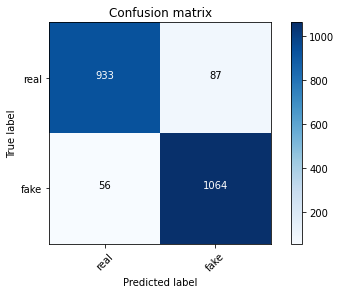

In [ ]:
import sklearn.metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

cm = confusion_matrix(test_labels, prediction_)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=["real","fake"], title='Confusion matrix')

In [ ]:
test_accuracy = (cm[0][0]+cm[1][1])/(cm[0][1]+cm[1][0]+cm[0][0]+cm[1][1])
precision = (cm[0][0])/(cm[1][0]+cm[0][0])
recall = (cm[0][0])/(cm[0][1]+cm[0][0])
f1_score = 2*(precision*recall)/(precision + recall)
print("Test Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Test Accuracy: 0.9331775700934579
Precision: 0.9433771486349848
Recall: 0.9147058823529411
F1 Score: 0.9288203086112493


###Test any custom news for credibility

In [ ]:
test_news = input("enter a news to test: ")
test_news = remove_noise(test_news)
test_news = remove_stopwords(test_news)
test_news = truncate(test_news)
test_news = [test_news]
test_news_ = pad_sequences(tokenizer.texts_to_sequences(test_news), maxlen=max_length)
result = model.predict(test_news_)
if(result[0][0]>=0.5):
    result[0][0] = 1
else:
    result[0][0] = 0
result_ = encoder.inverse_transform(result.astype(int).flatten())
print("Result: The news you entered is",result_[0])

enter a news to test: vaccination is dangerous and will cause a global catastrophe depopulation by vaccination
Result: The news you entered is fake


In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
import cv2
import pytesseract
import shutil
import os
import random

In [ ]:
img = cv2.imread('test_image.jpg')

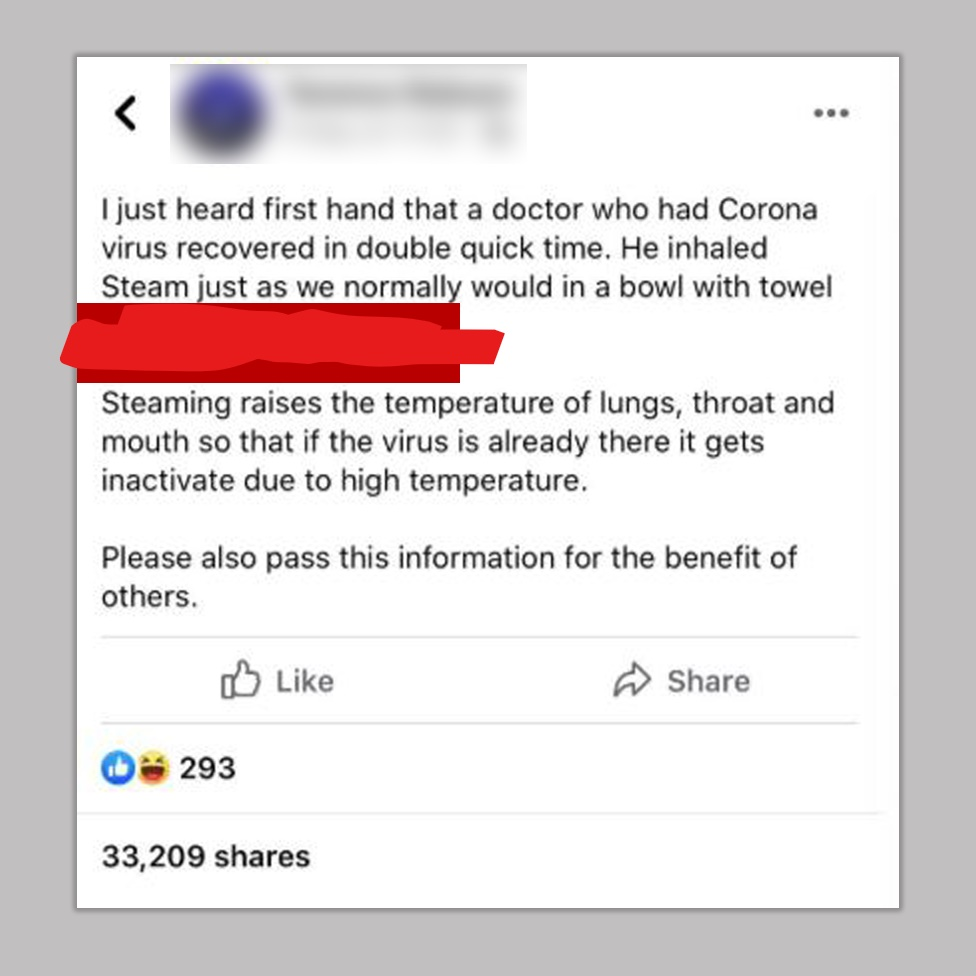

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

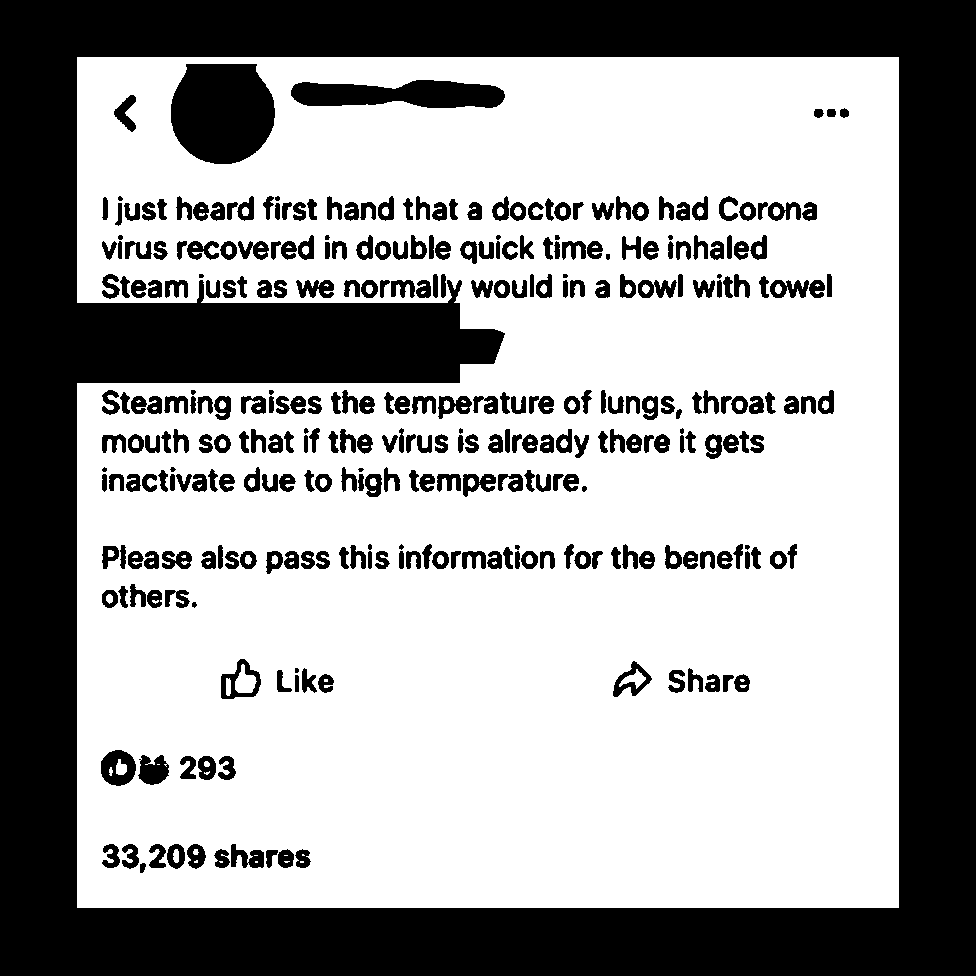

In [ ]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise_img(image):
    return cv2.GaussianBlur(image,(1,1),cv2.BORDER_DEFAULT) 

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

gray = get_grayscale(img)
thresh = thresholding(gray)
clean_img = remove_noise_img(thresh)
cv2_imshow(clean_img)

In [ ]:
import textwrap

###Extracting text using tesseract

In [ ]:
extracted_text = pytesseract.image_to_string(clean_img)
print("Raw text: \n", extracted_text)

Raw text: 
 ‘o--

| just heard first hand that a doctor who had Corona
virus recovered in double quick time. He inhaled
Steam just as we normally would in a bowl with towel

Steaming raises the temperature of lungs, throat and
mouth so that if the virus is already there it gets
inactivate due to high temperature.

Please also pass this information for the benefit of
others.

i) Like @ Share
Ow 293

33,209 shares

 



###Applying preprocessing to the extracted text


In [ ]:
extracted_text = remove_noise(extracted_text)
extracted_text = remove_stopwords(extracted_text)
extracted_text = truncate(extracted_text)
print("After applying preprocessing: ")
print (textwrap.fill(extracted_text, width=70))

After applying preprocessing: 
heard first hand doctor corona virus recovered double quick time
inhaled steam normally would bowl towel steaming raises temperature
lungs


###Testing if the extracted text contains a real or a fake news

In [ ]:
test_news = extracted_text
test_news = [test_news]
test_news_ = pad_sequences(tokenizer.texts_to_sequences(test_news), maxlen=max_length)
result = model.predict(test_news_)
if(result[0][0]>=0.5):
    result[0][0] = 1
else:
    result[0][0] = 0
result_ = encoder.inverse_transform(result.astype(int).flatten())
print("\nResult: The news in the image is",result_[0])


Result: The news in the image is fake


#Test the saved model

In [ ]:
from tensorflow import keras
test_news = input("enter a news to test: ")
test_news = remove_noise(test_news)
test_news = remove_stopwords(test_news)
test_news = truncate(test_news)
test_news = [test_news]


# loading tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    saved_tokenizer = pickle.load(handle)


test_news_ = pad_sequences(saved_tokenizer.texts_to_sequences(test_news), maxlen=max_length)


# !unzip my_model.zip -d /

saved_model = keras.models.load_model('/content/my_model')
result = saved_model.predict(test_news_)
if(result[0][0]>=0.5):
    result[0][0] = 1
else:
    result[0][0] = 0


# loading
with open('encoder.pickle', 'rb') as handle:
    saved_encoder = pickle.load(handle)

result_ = saved_encoder.inverse_transform(result.astype(int).flatten())
print("Result: The news you entered is",result_[0])

enter a news to test: vaccination is dangerous and will cause a global catastrophe depopulation by vaccination
Result: The news you entered is fake
